<a href="https://colab.research.google.com/github/aditiprashant07/BUSI-and-LoRA-Project-/blob/main/LoRAandBUSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Google Collabs runtime is temporary and to ensure it persists after disconnection. Without this you lose everything."""
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""This is the best practice to organize data"""
import os

PROJECT_ROOT = "/content/drive/MyDrive/BUSI_LoRA_Project"

folders = ["data", "checkpoints", "outputs"]

for folder in folders:
    os.makedirs(os.path.join(PROJECT_ROOT, folder), exist_ok=True)

print("Project folders created successfully!")


Project folders created successfully!


In [3]:
"""To check if torch and the specific GPU type is available"""
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: Tesla T4


In [4]:
"""Transformers -> Hugging Face pre-trained library
peft -> Parameter-Efficient Fine Tuning which enables LoRA
scikit-learn -> Metrics, Confusion Matrix, Classification report
Matplotlib -> For plotting training curves
GRAD-CAM -> Explainability - showing what the model sees"""
!pip install transformers
!pip install -q peft
!pip install -q scikit-learn
!pip install -q matplotlib

In [5]:
#Installing Kaggle from where our dataset will be pulled
!pip install -q kaggle


In [6]:
#This is important to create a kaggle.json file and for connecting to your Kaggle account.
import json
import os

kaggle_username = "username"
kaggle_key = "token"

kaggle_json = {
    "username": kaggle_username,
    "key": kaggle_key
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_json, f)

os.chmod("/root/.kaggle/kaggle.json", 600)

print("kaggle.json created successfully!")


kaggle.json created successfully!


In [7]:
!kaggle datasets list -s breast-ultrasound


ref                                                              title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
aryashah2k/breast-ultrasound-images-dataset                      Breast Ultrasound Images Dataset                   204421470  2021-03-14 04:29:54.023000          63712        468  1.0              
vuppalaadithyasairam/ultrasound-breast-images-for-breast-cancer  Ultrasound Breast Images for Breast Cancer         591742845  2022-11-03 05:51:50.933000           4428         60  0.75             
orvile/bus-uc-breast-ultrasound                                  BUS_UC - Breast Ultrasound Dataset                 143163924  2025-07-06 00:01:54.773000            848         35  1.0              
sabah

In [8]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 77% 150M/195M [00:00<00:00, 1.57GB/s]
100% 195M/195M [00:00<00:00, 1.16GB/s]


In [9]:
!unzip breast-ultrasound-images-dataset.zip -d data/


Archive:  breast-ultrasound-images-dataset.zip
  inflating: data/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: data/Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating:

In [10]:
"""In each transformation of image we have a resize since ViT an DeiT require a 224x224 ImageNet Images.
After resizing the Image is converted into a tensor value between 0 and 1.
The Normalization is used at the end since ViT was trained on these standard values. Without this the model sees data which is out of it's distribution"""
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# ImageNet normalization values (required for pretrained ViT)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [11]:
"""ImageFolder automatically assigns ;abels based on folder names. This is to ensure data remains consistent"""
dataset_path = "data/Dataset_BUSI_with_GT"

full_dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=transform
)

print("Total images:", len(full_dataset))
print("Classes:", full_dataset.classes)


Total images: 1578
Classes: ['benign', 'malignant', 'normal']


In [12]:
"""This is standard pattern for small datasets and a random split ensures random distributions"""
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))


Train size: 1262
Validation size: 316


In [13]:
#Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [14]:
#Testing One Batch to check if pre processing works
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8])


In [16]:
#Loading our vision transformer-facebook/deit-small-patch16-224
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "facebook/deit-small-patch16-224"

processor = AutoImageProcessor.from_pretrained(model_name)

model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=3,
    ignore_mismatched_sizes=True # Add this line to handle the mismatch
)

model.to(device)

print("Model loaded successfully.")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: facebook/deit-small-patch16-224
Key               | Status   |                                                                                        
------------------+----------+----------------------------------------------------------------------------------------
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([3])          
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 384]) vs model:torch.Size([3, 384])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


Model loaded successfully.


In [17]:
# This is a sanity check
outputs = model(images.to(device))
print(outputs.logits.shape)


torch.Size([8, 3])


In [18]:
# Now we begin training the LoRA layers and the Classification Heads- We also need to freeze the base model in this step
for param in model.base_model.parameters():
    param.requires_grad = False

print("Base model frozen.")


Base model frozen.


In [20]:
# We apply LoRA to the attention layers
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none"
    # Removed: task_type="IMAGE_CLASSIFICATION" as it's not a valid type
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 147,456 || all params: 21,814,275 || trainable%: 0.6760


In [22]:
# Define Optimizer and Loss
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5
)



In [23]:
scaler = torch.cuda.amp.GradScaler()


/tmp/ipython-input-2655216266.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [24]:
# Create a clean and simple training loop
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader)}")



/tmp/ipython-input-3699784098.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 Loss: 0.9290571895581258
Epoch 2 Loss: 0.6326180751187892
Epoch 3 Loss: 0.4600442251827143
Epoch 4 Loss: 0.34673144243940524
Epoch 5 Loss: 0.28268607055084616


In [25]:
# After each epoch run this for validation accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Validation Accuracy:", 100 * correct / total, "%")


Validation Accuracy: 90.82278481012658 %


In [26]:
# Creating a Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.logits, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


              precision    recall  f1-score   support

      benign       0.90      0.94      0.92       178
   malignant       0.95      0.84      0.89        89
      normal       0.88      0.90      0.89        49

    accuracy                           0.91       316
   macro avg       0.91      0.89      0.90       316
weighted avg       0.91      0.91      0.91       316



In [28]:
# Install Grad-CAM for medical imaging explainability
!pip install grad-cam -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [30]:
#Import the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [45]:
# Put model in EVAL mode
model.eval()


PeftModel(
  (base_model): LoraModel(
    (model): ViTForImageClassification(
      (vit): ViTModel(
        (embeddings): ViTEmbeddings(
          (patch_embeddings): ViTPatchEmbeddings(
            (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): ViTEncoder(
          (layer): ModuleList(
            (0-11): 12 x ViTLayer(
              (attention): ViTAttention(
                (attention): ViTSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=384, out_features=384, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=384, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (

In [46]:
# Define a Reshape Function
def reshape_transform(tensor):
    # Remove class token
    tensor = tensor[:, 1:, :]

    h = w = 14  # because image is 224 and patch size is 16 (224/16=14)

    tensor = tensor.reshape(tensor.size(0), h, w, tensor.size(2))
    tensor = tensor.permute(0, 3, 1, 2)  # (B, C, H, W)

    return tensor


In [47]:
# Wrap the model
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

wrapped_model = ModelWrapper(model)
wrapped_model.eval()


ModelWrapper(
  (model): PeftModel(
    (base_model): LoraModel(
      (model): ViTForImageClassification(
        (vit): ViTModel(
          (embeddings): ViTEmbeddings(
            (patch_embeddings): ViTPatchEmbeddings(
              (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): ViTEncoder(
            (layer): ModuleList(
              (0-11): 12 x ViTLayer(
                (attention): ViTAttention(
                  (attention): ViTSelfAttention(
                    (query): lora.Linear(
                      (base_layer): Linear(in_features=384, out_features=384, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, inplace=False)
                      )
                      (lora_A): ModuleDict(
                        (default): Linear(in_features=384, out_features=8, bias=False)
                    

In [50]:
# Select correct target layer
target_layer = model.base_model.model.vit.encoder.layer[-1].layernorm_after


In [51]:
# Initialize GRAD-CA<
cam = GradCAM(
    model=wrapped_model,
    target_layers=[target_layer],
    reshape_transform=reshape_transform
)


In [52]:
# Get one validation image
images, labels = next(iter(val_loader))

image = images[0].unsqueeze(0).to(device)
label = labels[0].item()


In [53]:
# Generate GRAD-CAM heatmap
targets = [ClassifierOutputTarget(label)]

grayscale_cam = cam(input_tensor=image, targets=targets)
grayscale_cam = grayscale_cam[0]


In [54]:
# Undo normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img = images[0].permute(1, 2, 0).cpu().numpy()
img = std * img + mean
img = np.clip(img, 0, 1)


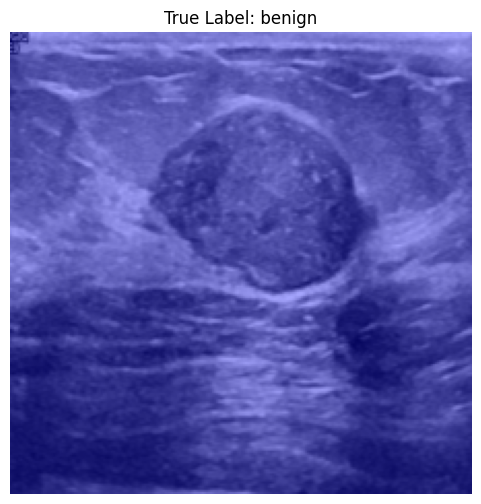

In [55]:
# Overlap Heatmap
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6,6))
plt.imshow(visualization)
plt.title(f"True Label: {full_dataset.classes[label]}")
plt.axis("off")
plt.show()
